In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.text as mpltxt
import matplotlib.cm as cm
import pickle # for .pkl files
import h5py   # for .jld2 files
import os
import torch
from sklearn.decomposition import PCA
import seaborn as sns
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
###
#  figure settings 
###
sns.set(style='ticks', palette='Set2', font_scale=1.5, rc={"lines.linewidth": 3})
sns.despine()
# plt.rcParams.update({'font.size': 16})
# plt.rcParams['figure.dpi'] = 1200 # 600-1200 for paper quality
save_plots = True

<Figure size 640x480 with 0 Axes>

## Load Data

In [3]:
# fideltiy values
lf_val = 1/3 # low-fidelity
hf_val = 2/3 # high-fidelity

In [4]:
###
#  construct a single dictionary from those of all the runs
###
def get_bo_res(which_results: str, nb_run: int, norm_type):
    assert "results" in which_results
    # initialize dict to store results 
    bo_res = pickle.load(
             open('search_results/{}/{}/{}_run_{}.pkl'.format(norm_type, 
                                                              which_results, 
                                                              which_results, 0), 'rb'))
    for key in bo_res.keys():
        bo_res[key] = []
        
    # iterate though the runs
    for n in range(nb_run):
        # get results dict for specified run
        bo_res_file = pickle.load(
                     open('search_results/{}/{}/{}_run_{}.pkl'.format(norm_type, 
                                                                      which_results, 
                                                                      which_results, n), 'rb'))
        
        # append results to end of list
        for key in bo_res_file.keys():
            key_res = bo_res_file[key]
            bo_res[key].append(key_res)
            
    return bo_res

In [5]:
###
#  features and molecular simulation data
###
normalization = "normalized" 
file = h5py.File("targets_and_{}_features.jld2".format(normalization), "r")

# feature matrix
X = torch.from_numpy(np.transpose(file["X"][:])) 
# simulation data
y = [np.transpose(file["henry_y"][:]), 
     np.transpose(file["gcmc_y"][:])]  

# associated simulation costs
cost = [np.transpose(file["henry_total_elapsed_time"][:]), # [min]
        np.transpose(file["gcmc_elapsed_time"][:])]        # [min]

# total number of COFs in data set
nb_COFs = X.shape[0]

###
#  bayesian optimization data
###
# COF IDs used for initialization
init_cof_ids_file = pickle.load(open('search_results/{}/initializing_cof_ids_{}.pkl'.format(normalization, 
                                                                           normalization), 'rb'))
init_cof_ids = init_cof_ids_file['init_cof_ids']

nb_COFs_initialization = len(init_cof_ids[0])
nb_runs = len(init_cof_ids)

# random search 
random_search_res = pickle.load(open('search_results/{}/random_search_results.pkl'.format(normalization), 'rb'))

# multi-fidelity search
mfbo_res = get_bo_res('mfbo_results', nb_runs, normalization)

# single-fideliy search
sfbo_res = get_bo_res('sfbo_results', nb_runs, normalization)

# number of iterations per run
nb_iters = len(mfbo_res['acquired_set'][0])

###
#  quick checks
###
# structure of data
assert len(sfbo_res['ids_acquired'][0]) == nb_iters
assert len(random_search_res['ids_acquired'][0]) == nb_COFs # nb_iterations
assert sfbo_res['nb_COFs_initialization'][0] == nb_COFs_initialization

# each run has the correct initializing COFs
assert all([all(sfbo_res['ids_acquired'][r][:nb_COFs_initialization] == init_cof_ids[r]) 
            for r in range(nb_runs)])

## Prreliminary Analysis

In [6]:
# the max number of iterations needed for any of the runs
max_SFBO_iters = max(sfbo_res['BO_iter_top_cof_acquired'])
max_MFBO_iters = max(mfbo_res['BO_iter_top_cof_acquired'])

# the highest accumulated cost up to the max number of iterations needed
max_SFBO_cost = np.max(sfbo_res['accumulated_cost'][:][:max_SFBO_iters+1])
max_MFBO_cost = np.max(mfbo_res['accumulated_cost'][:][:max_MFBO_iters+1])


print("The max number of iterations needed for any of the runs -")
print("\tSFBO: {}".format(max_SFBO_iters))
print("\tMFBO: {}".format(max_MFBO_iters))
print("The highest accumulated cost up to the max number of iterations needed -")
print("\tSFBO: {} [hr]".format(max_SFBO_cost))
print("\tMFBO: {} [hr]".format(max_MFBO_cost))

The max number of iterations needed for any of the runs -
	SFBO: 101
	MFBO: 125
The highest accumulated cost up to the max number of iterations needed -
	SFBO: 704.8861669608626 [hr]
	MFBO: 345.67138266397825 [hr]


In [7]:
###
#  cost of doing an exhaustive low-fidelity search 
#  and itteraing down the list with high-fidelity simulations
#  until you simulate the Top COF.
###
total_lf_cost = sum(cost[0]) / 60 # [hr]
# sort COFs by selectivity in decenting order
lf_y_sorted = y[0].argsort()[::-1]
# get index of high-fidelity Top COF
hf_top_cof_id =  np.where(lf_y_sorted == np.argmax(y[1]))[0].item()
# add in the high-fidelity cost
lf_exhaustive_search_cost = total_lf_cost + (sum(cost[1][lf_y_sorted[:hf_top_cof_id+1]]) / 60) # [hr]
print("low-fidelity exhaustive search cost = ", lf_exhaustive_search_cost, " [hr]")

low-fidelity exhaustive search cost =  189.32410748448632  [hr]


In [8]:
###
#  cost of SFBO to find Top COF
#  initialized with max diverse set
###
sfbo_res['BO_iter_top_cof_acquired'][0] # 87
sfbo_res['ids_acquired'][0][87] # 375
cost[1][375] / 60 # 16.71 [hrs], hf cost of TOP COF
sfbo_cost = sum(sfbo_res['cost_acquired'][0][:sfbo_res['BO_iter_top_cof_acquired'][0]+1]) / 60 # [hr]
print("cost of SFBO search to find Top COF: " , sfbo_cost, " hrs")

cost of SFBO search to find Top COF:  314.9184591303931  hrs


In [9]:
# total hf cost of 
mfbo_top_cof_id = mfbo_res['BO_iter_top_cof_acquired'][0] # 47
mfbo_res['accumulated_cost'][0][mfbo_top_cof_id] # [hrs], 57.8
print("cost of MFBO search to find Top COF: " , mfbo_res['accumulated_cost'][0][mfbo_top_cof_id], " hrs")

# How much does the MFBO cost compare to the SFBO cost?
ratio_mfbo_sfbo = mfbo_res['accumulated_cost'][0][mfbo_top_cof_id] / sfbo_cost
print("cost ratio of MFBO to SFBO search: ", ratio_mfbo_sfbo)

# How much does the MFBO cost compared to a high-fidelity exhaustive search?
gcmc_exhaustive_search_cost = sum(cost[1]) / 60 # [hrs], exhaustive high-fidelity search
ratio_mfbo_exh = mfbo_res['accumulated_cost'][0][mfbo_top_cof_id] / gcmc_exhaustive_search_cost
print("cost ratio of MFBO to GCMC exhaustive search: ", ratio_mfbo_exh)

# How much of the MFBO search cost is due to high-fidelity evalutations?
where_fids = np.where([mfbo_res['acquired_set'][0][:, 0] == 2/3])
mfbo_hf_fraction = sum(mfbo_res['cost_acquired'][0][where_fids[1][:9]]) / 60 # [hrs]
mfbo_hf_fraction /= mfbo_res['accumulated_cost'][0][mfbo_top_cof_id]
print("proportion of high-fidelity cost in MFBO search: ", mfbo_hf_fraction)

cost of MFBO search to find Top COF:  57.80021943906943  hrs
cost ratio of MFBO to SFBO search:  0.18354027134096018
cost ratio of MFBO to GCMC exhaustive search:  0.024791415560779052
proportion of high-fidelity cost in MFBO search:  0.8431362615270684


# Plot Search Results 

In [10]:
def get_distribution(res, maxes=False):
    # initialize arrays for dist.
    mu      = np.zeros(nb_iters)
    sig_bot = np.zeros(nb_iters)
    sig_top = np.zeros(nb_iters)
    
    ###
    #  look at all runs and get the dist.
    ###
    for i in range(1, nb_iters+1):
        if maxes:
            # max value acquired up to this point (over all runs)       
            vals_at_iter = np.array([max(res[r][:i]) for r in range(nb_runs)])
        else:
            # make an arrey of all the values at a given iteration
            vals_at_iter = np.array([res[r][i-1] for r in range(nb_runs)])
        assert np.size(vals_at_iter) == nb_runs
        mu[i-1]      = np.mean(vals_at_iter)
        sig_bot[i-1] = np.std(vals_at_iter[vals_at_iter < mu[i-1]])
        sig_top[i-1] = np.std(vals_at_iter[vals_at_iter > mu[i-1]])
        
    return  mu, sig_bot, sig_top

In [11]:
###
#  when, on average, is the top COF located? 
###
mfbo_mean_iter_top_cof = int(np.round(np.mean(mfbo_res['BO_iter_top_cof_acquired'])))
sfbo_mean_iter_top_cof = int(np.round(np.mean(sfbo_res['BO_iter_top_cof_acquired'])))

print("Average iterations to locate top COF - ")
print("MFBO:\t", mfbo_mean_iter_top_cof)
print("SFBO:\t", sfbo_mean_iter_top_cof)

Average iterations to locate top COF - 
MFBO:	 48
SFBO:	 76


SFBO  max search time =  456.2303129938576
SFBO  avg search time =  260.8919535738408
MFBO  max search time =  169.97261515571014
MFBO  avg search time =  57.55046238002049


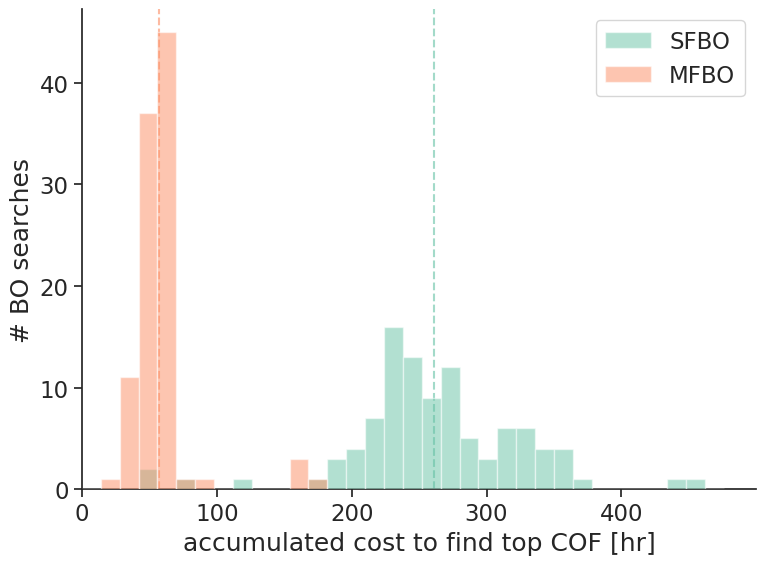

In [12]:
###
#  make a histogram of the distribution of accumulated cost 
###
fig = plt.figure(figsize=(8, 6))
width = 14
bins = np.array([int(width*i) for i in range(int(500 / width))])

for i, res, search_type in zip([0, 1], [sfbo_res, mfbo_res], ["SFBO", "MFBO"]):
    x = []
    # color
    color = "C{}".format(i)
    
    for r in range(nb_runs):
        n = res['BO_iter_top_cof_acquired'][r]
        x.append(res['accumulated_cost'][r][n])
    
    print(search_type, " max search time = ", np.max(x))
    print(search_type, " avg search time = ", np.mean(x))
    plt.axvline(x=np.mean(x), color=color, linestyle="--", lw=1.5, alpha=0.6)
    plt.hist(x, bins, label=search_type, color=color, alpha=0.5, zorder=10)


###
#  axis settings
###
plt.xlim(xmin=0)
plt.xlabel('accumulated cost to find top COF [hr]')
plt.ylabel('# BO searches')
plt.legend()

sns.despine()
plt.tight_layout()
if save_plots:
    plt.savefig("./figs/hist_accumulated_cost_destribution.pdf", format="pdf")
plt.show()

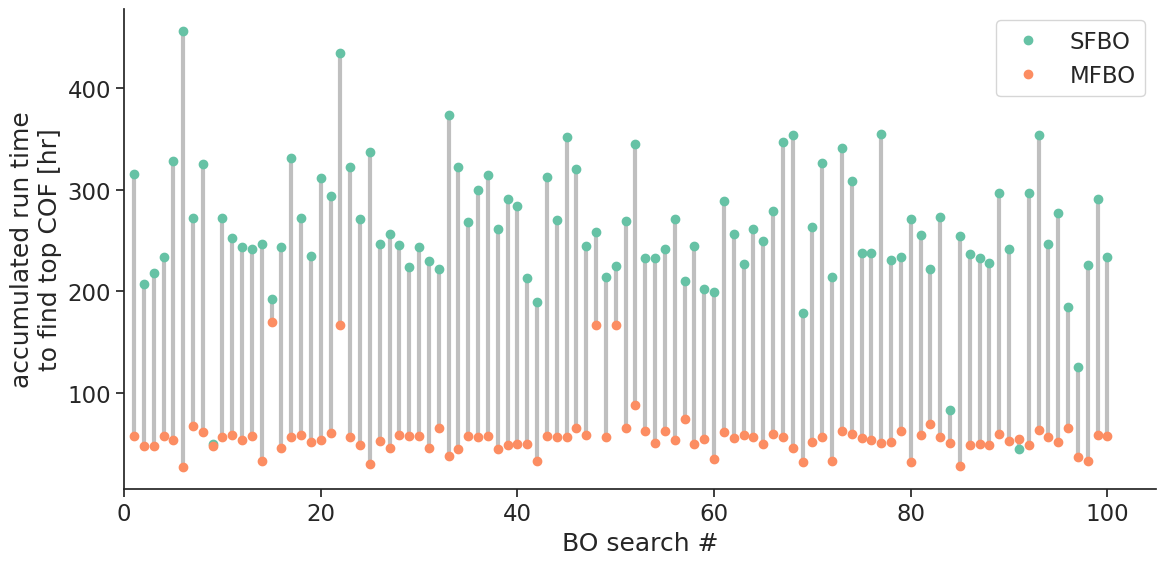

In [13]:
###
#  make a histogram of the distribution of accumulated cost 
###
fig = plt.figure(figsize=(12, 6))



for r in range(nb_runs):
    sfbo_n = sfbo_res['BO_iter_top_cof_acquired'][r]
    sfbo_y = sfbo_res['accumulated_cost'][r][sfbo_n]
    plt.scatter(r+1, sfbo_y,
                color='C0', marker='o', zorder=100)

    mfbo_n = mfbo_res['BO_iter_top_cof_acquired'][r]
    mfbo_y = mfbo_res['accumulated_cost'][r][mfbo_n]
    plt.scatter(r+1, mfbo_y,  
                color='C1', marker='o', zorder=100)

    # single vline with specific ymin and ymax
    y_min = np.minimum(mfbo_y, sfbo_y)
    y_max = np.maximum(mfbo_y, sfbo_y)
    plt.vlines(x=r+1, ymin=y_min, ymax=y_max, colors='gray', zorder=50, alpha=0.5)



# dummy plots for legend
p_empty_cir = plt.plot([], marker='o', linestyle='none', 
                          markerfacecolor='C0', markeredgecolor='C0', label='SFBO')
p_empty_sqr = plt.plot([], marker='o', linestyle='none', 
                          markerfacecolor='C1', markeredgecolor='C1', label='MFBO')

plt.legend()


###
#  axis settings
###
plt.xlim(xmin=0)
plt.ylabel('accumulated run time\nto find top COF [hr]')
plt.xlabel('BO search #')
# plt.legend()

sns.despine()
plt.tight_layout()
if True: #save_plots:
    plt.savefig("./figs/diff_in_accumulated_cost_destribution.pdf", format="pdf")
plt.show()

## Search Efficientcy Curves

In [14]:
### 
#  get the maximum selectivity from a running list
###
def get_y_maxes_acquired(y_acquired):
    nb_iters = len(y_acquired)
    return [max(y_acquired[:i+1]) for i in range(nb_iters)]  

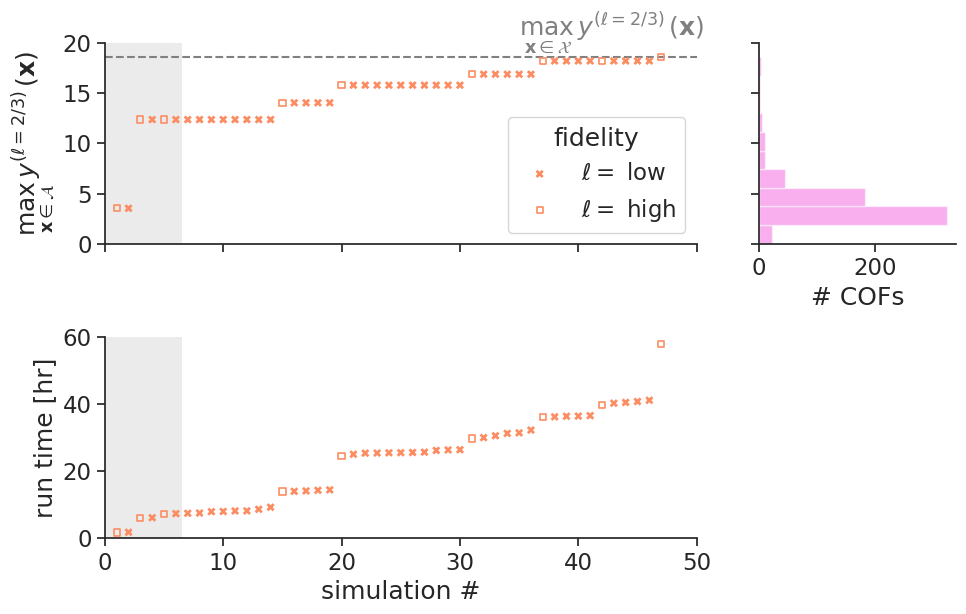

In [45]:
###
#  define constants useful for plotting
###
iter_start = 2 * nb_COFs_initialization
iter_top_cof_acquired = mfbo_res['BO_iter_top_cof_acquired'][0] 
iter_range = np.array(range(nb_iters)) 



_fids = mfbo_res['acquired_set'][0][:, 0]
mfbo_ymax_acq = mfbo_res['y_max_acquired'][0][:iter_top_cof_acquired+1]
mfbo_acc_cost = mfbo_res['accumulated_cost'][0][:iter_top_cof_acquired+1]

###
#  plot
###
gridspec_kw={'width_ratios': [6, 2], 'height_ratios': [4, 4]} # set ratios
fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw=gridspec_kw, figsize=(10, 6.5))

plt.subplots_adjust(hspace=0)

###
#  search efficiency vs accumulated cost
#  include scatter for search start and stop
###
ax[0,0].scatter(np.where(_fids[:iter_top_cof_acquired+1] == lf_val)[0][1:], 
                mfbo_ymax_acq[_fids[:iter_top_cof_acquired+1] == lf_val][1:],    
                label=r"$\ell =$ low",
                ec='C1', marker="x", fc="none", s=20, zorder=10, lw=2) 

ax[0,0].scatter(np.where(_fids[:iter_top_cof_acquired+1] == hf_val)[0], 
                mfbo_ymax_acq[_fids[:iter_top_cof_acquired+1] == hf_val],   
                label=r"$\ell =$ high",
                ec='C1', fc='none', marker="s", s=20, zorder=10, lw=1.2)

ax[0,0].axvspan(0, iter_start+0.5, color='C7', alpha=0.25, lw=0)

plt.setp(ax[0,0].get_xticklabels(), visible=False) # remove yticklabels


###  
#  global maximum
###
ax[0,0].axhline(y=max(y[1]), color="gray", ls="--", lw=1.5)
ax[0,0].text(35.0, max(y[1]) + 2.2, 
           r"$\max_{\mathbf{x} \in \mathcal{X}}\, y^{(\ell=2/3)}(\mathbf{x})$", 
           color="gray")


###
#  histogram of selectivities
###
hist_cbar = sns.color_palette("husl", 8)
ax[0,1].hist(y[1], color=hist_cbar[7], alpha=0.5, orientation='horizontal')
ax[0,1].sharey(ax[0,0])
# ax[0,1].set_xscale('log')
ax[0,1].set_xlabel('# COFs')
plt.setp(ax[0,1].get_yticklabels(), visible=False) # remove yticklabels


###
#  Accumulated cost
###
ax[1,0].sharex(ax[0,0])


ax[1,0].scatter(np.where(_fids[:iter_top_cof_acquired+1] == lf_val)[0][1:], 
                mfbo_acc_cost[_fids[:iter_top_cof_acquired+1] == lf_val][1:], 
                label='accumulated cost', 
                marker="x", ec='C1', fc='none', s=20, zorder=10, lw=2) # fc="none",

ax[1,0].scatter(np.where(_fids[:iter_top_cof_acquired+1] == hf_val)[0], 
                mfbo_acc_cost[_fids[:iter_top_cof_acquired+1] == hf_val], 
                label='accumulated cost', 
                ec='C1', fc='none', marker="s", s=20, zorder=10, lw=1.2)

ax[1,0].axvspan(0, iter_start + 0.5, color='C7', alpha=0.25, lw=0)

ax[1,0].set_ylim(ymin=-0, ymax=60)
ax[1,0].set_xlabel('simulation #')
ax[1,0].set_ylabel("run time [hr]")
# plt.setp(ax[1,0].get_xticklabels(), visible=False) # remove yticklabels


###
#  remove extra axis
###
plt.delaxes(ax[1,1])

###
#  axis settings
###
# search efficiency 
ax[0,0].set_xlim(xmin=-0, xmax=50)
ax[0,0].set_ylim(ymin=0, ymax=20)
ax[0,0].set_ylabel(r'$\max_{\mathbf{x} \in \mathcal{A}}\, y^{(\ell=2/3)}(\mathbf{x})$')
ax[0,0].legend(title="fidelity", loc=4, ncol=1)


plt.tight_layout()
sns.despine()
if True: #save_plots:
    plt.savefig("./figs/MFBO_multipanel.pdf", bbox_inches="tight", format="pdf")
plt.show()

SFBO
2
87
314.9184591303931
MFBO
5
47
57.80021943906943


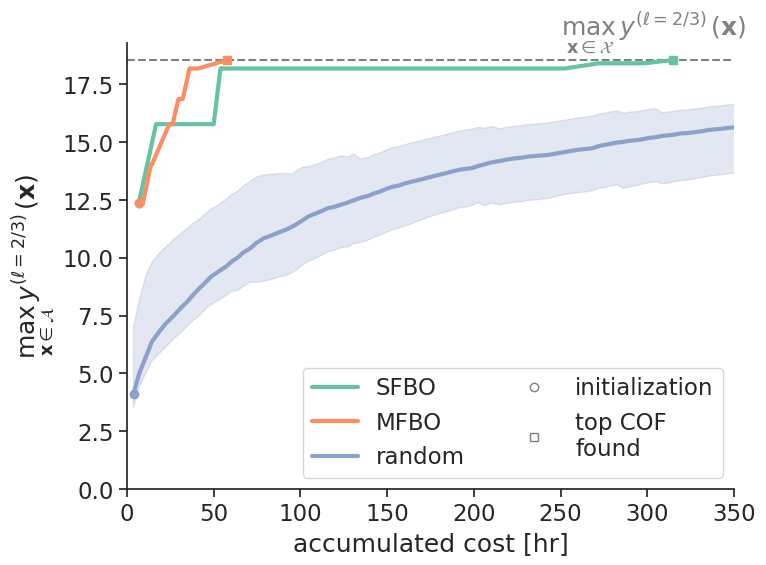

In [16]:
fig = plt.figure(figsize=(8, 6))  
# markers = dict({0 : '+', 1: 'x'})

for i, res, search_type in zip([0, 1], [sfbo_res, mfbo_res], ["SFBO", "MFBO"]):
    # color
    color = "C{}".format(i)
    
    # important indexes
    print(search_type)
    iter_start = nb_COFs_initialization * (i + 1) - 1 # i + 1 is convenient hack :)
    print(iter_start)
    iter_top_cof_acquired = res['BO_iter_top_cof_acquired'][0]
    print(iter_top_cof_acquired)
    print(res['accumulated_cost'][0][iter_top_cof_acquired])
    
    iter_range = np.array(range(nb_iters)) # range(iter_start, nb_iters)
    
    ###
    #  search efficiency vs accumulated cost
    ###
    plt.plot(res['accumulated_cost'][0][iter_start:iter_top_cof_acquired + 1], 
             res['y_max_acquired'][0][iter_start:iter_top_cof_acquired + 1],    
             label=search_type, 
             color=color, zorder=10)

    # start and stop
    plt.scatter([res['accumulated_cost'][0][iter_start]], 
                [res['y_max_acquired'][0][iter_start]],  
                color=color, marker="o", zorder=100)
    
    plt.scatter([res['accumulated_cost'][0][iter_top_cof_acquired]], 
                res['y_max_acquired'][0][iter_top_cof_acquired+1],  
                color=color, marker="s", zorder=100)
    

###
#  random search (high-fidelity, l=1)
###
iter_stop = np.max(mfbo_res['BO_iter_top_cof_acquired']) + 1
# accumulated cost
acc_cost_mu, acc_cost_sig_bot, acc_cost_sig_top = get_distribution(random_search_res['accumulated_cost'])

plt.plot(acc_cost_mu[:iter_stop], 
         random_search_res['y_rs_max_mu'][:iter_stop], 
         label="random", color="C2", zorder=2)

plt.fill_between(acc_cost_mu[:iter_stop], 
                 random_search_res['y_rs_max_mu'][:iter_stop] - 
                 random_search_res['y_rs_max_sig_bot'][:iter_stop], 
                 random_search_res['y_rs_max_mu'][:iter_stop] + 
                 random_search_res['y_rs_max_sig_top'][:iter_stop], 
                 alpha=0.25, color="C2", zorder=1)

# start and stop
plt.scatter([acc_cost_mu[0]], [random_search_res['y_rs_max_mu'][0]],
            color="C2", marker="o", zorder=100)

# plt.scatter([acc_cost_mu[iter_stop-1]], [random_search_res['y_rs_max_mu'][iter_stop-1]],   
#             color="C2", marker="s", zorder=100)

###  
#  global maximum
###
plt.axhline(y=max(y[1]), color="gray", ls="--", lw=1.5)
plt.text(250.0, max(y[1]) + 1.1, 
           r"$\max_{\mathbf{x} \in \mathcal{X}}\, y^{(\ell=2/3)}(\mathbf{x})$", 
           color="gray")

###
#  axis settings
###
# search efficiency 
plt.xlim(xmin=0, xmax=350)
plt.ylim(ymin=0)
plt.xlabel("accumulated cost [hr]")
plt.ylabel(r'$\max_{\mathbf{x} \in \mathcal{A}}\, y^{(\ell=2/3)}(\mathbf{x})$')

# dummy plots for legend
p_empty_cir = plt.plot([], marker='o', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='initialization')
p_empty_sqr = plt.plot([], marker='s', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='top COF\nfound')

plt.legend(loc=4, ncol=2)



plt.tight_layout()
sns.despine()
if save_plots:
    plt.savefig("./figs/AccCost_vs_SearchEfficiency.pdf", format="pdf")
plt.show()

### Plot Search Traces

100


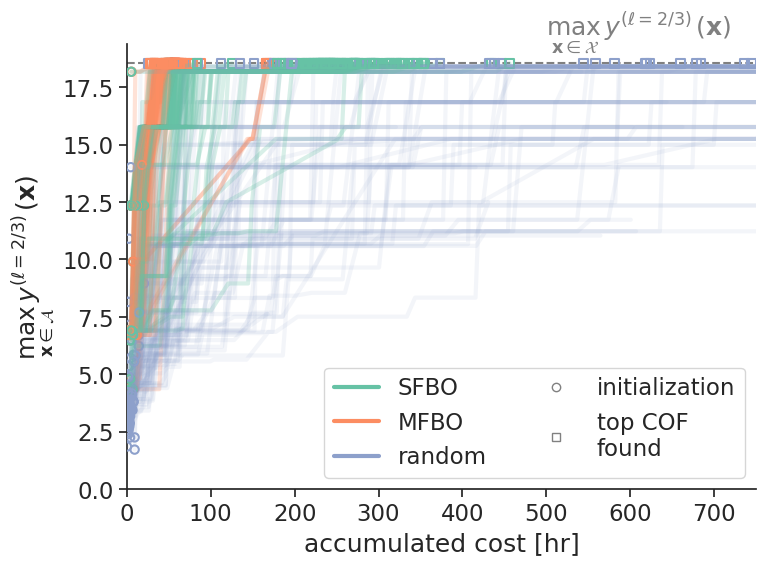

In [17]:
fig = plt.figure(figsize=(8, 6))

# loop over search types
for i, res, search_type in zip([0, 1], [sfbo_res, mfbo_res], ["SFBO", "MFBO"]):
    # color
    color = "C{}".format(i)

    # loop over search results
    for j in range(len(res['y_max_acquired'])):
        # zorder
        z = np.random.randint(100)
        # important indexes
        iter_start = nb_COFs_initialization * (i + 1) - 1 # i + 1 is convenient hack :)
        iter_top_cof_acquired = res['BO_iter_top_cof_acquired'][j]   
        iter_range = np.array(range(nb_iters)) # range(iter_start, nb_iters)
    
        ###
        #  search efficiency vs accumulated cost
        ###
        plt.plot(res['accumulated_cost'][j][iter_start:iter_top_cof_acquired + 1], 
                res['y_max_acquired'][j][iter_start:iter_top_cof_acquired + 1],    
                color=color, zorder=z, alpha=0.25)

        # start and stop
        plt.scatter([res['accumulated_cost'][j][iter_start]], 
                    [res['y_max_acquired'][j][iter_start]],  
                    fc="none", ec=color, marker="o", lw=1.5, zorder=z)
        
        plt.scatter([res['accumulated_cost'][j][iter_top_cof_acquired]], 
                    res['y_max_acquired'][j][iter_top_cof_acquired+1],  
                    fc="none", ec=color, marker="s", lw=1.5, zorder=z)


###
#  random search traces
###
rs_ids_acquired = np.random.choice(range(len(random_search_res['ids_acquired'])), replace=False, size=100)
# track how many of these runs find the Top COF
rs_acquired_top_cof = 0
# loop over selected runs
for i, rs_search_id in enumerate(rs_ids_acquired):
    z = np.random.randint(100)
    rs_ids = random_search_res['ids_acquired'][rs_search_id]
    rs_y_maxes = get_y_maxes_acquired(y[1][rs_ids.tolist()].tolist())
    acq_top_cof = False
    if np.argmax(y[1]) in rs_ids:
        iter_stop = np.argmax(rs_y_maxes)
        acq_top_cof = True
        rs_acquired_top_cof += 1
    else:
        iter_stop = len(rs_y_maxes)
    # in the event that the top COF is the initial entry
    if iter_stop == 0:
        iter_stop = 1

    plt.plot(random_search_res['accumulated_cost'][rs_search_id].tolist()[:iter_stop], 
             rs_y_maxes[:iter_stop], 
             color='C2', alpha=0.1, zorder=z)
    
    # start and stop
    plt.scatter([random_search_res['accumulated_cost'][rs_search_id].tolist()[0]], 
                [rs_y_maxes[0]],  
                fc="none", ec='C2', marker="o", lw=1.5, zorder=z)
    
    if acq_top_cof:
        plt.scatter([random_search_res['accumulated_cost'][rs_search_id].tolist()[iter_stop]], 
                    [rs_y_maxes[iter_stop]],  
                    fc="none", ec='C2', marker="s", lw=1.5, zorder=z)

print(rs_acquired_top_cof)

###  
#  global maximum
###
plt.axhline(y=max(y[1]), color="gray", ls="--", lw=1.5)
plt.text(500.0, max(y[1]) + 1.25, 
           r"$\max_{\mathbf{x} \in \mathcal{X}}\, y^{(\ell=2/3)}(\mathbf{x})$", 
           color="gray")

###
#  axis settings
###
# search efficiency 
plt.xlim(xmin=0, xmax=750)
plt.ylim(ymin=0)
plt.xlabel("accumulated cost [hr]")
plt.ylabel(r'$\max_{\mathbf{x} \in \mathcal{A}}\, y^{(\ell=2/3)}(\mathbf{x})$')

###
#  dummy plots for legend labels
###
plt.plot([], [], label='SFBO', color='C0')
plt.plot([], [], label='MFBO', color='C1')
plt.plot([], [], label='random', color='C2')
p_empty_cir = plt.plot([], marker='o', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='initialization')
p_empty_sqr = plt.plot([], marker='s', linestyle='none', 
                          markerfacecolor='none', markeredgecolor='grey', label='top COF\nfound')

plt.legend(loc=4, ncol=2)



plt.tight_layout()
sns.despine()
if save_plots:
    plt.savefig("./figs/AccCost_vs_SearchEfficiency_AllRuns.pdf", format="pdf")
plt.show()

#### check distribution of initializing COF selectivities and costs

In [18]:
# gridspec_kw={'width_ratios': [6, 2], 'height_ratios': [4, 4]} # set ratios
# fig, ax = plt.subplots(nrows=2, ncols=2, gridspec_kw=gridspec_kw, figsize=(10, 6.5))

# ###
# #  scatter of high-fidelity cost vs selectivity
# ###
# # ax[0,1].set_xlabel('# COFs')
# # plt.setp(ax[0,1].get_yticklabels(), visible=False) # remove yticklabels

# ax[1,0].scatter(cost[1], y[1], color='C7', alpha=0.5, zorder=10)
# ax[1,0].set_xscale("log")
# ax[1,0].set_xlim(xmin=1, xmax=10000)
# ax[1,0].set_xlabel("hf cost")
# ax[1,0].set_ylabel("hf selectivity")

# ###
# #  histogram of selectivities
# ###
# hist_cbar = sns.color_palette("husl", 8)
# ax[1,1].sharey(ax[1,0])
# ax[1,1].hist(y[1], color=hist_cbar[7], alpha=0.5, orientation='horizontal')

# ax[0,0].sharex(ax[1,0])
# ax[0,0].hist(cost[1], bins=1000, color=hist_cbar[7], alpha=0.5)
# ax[0,0].set_xscale("log")

# ###
# #  remove extra axis
# ###
# plt.delaxes(ax[0,1])


# ###
# #  plot the distribution of initializing COFs
# ###
# for i, sfbo_y in enumerate(sfbo_res['y_acquired']):
#     ax[1,0].scatter(sfbo_res['cost_acquired'][i][0], sfbo_y[0], color='C0', zorder=100)


# ###
# #  make legend
# ###
# p_empty_cir = ax[1,0].plot([], marker='o', linestyle='none', 
#                           markerfacecolor='C7', markeredgecolor='C7', label='full data set')
# p_empty_sqr = ax[1,0].plot([], marker='o', linestyle='none', 
#                           markerfacecolor='C0', markeredgecolor='C0', label='SFBO')

# ax[1,0].legend()


# plt.tight_layout()
# plt.show()

In [19]:
# fig = plt.figure(figsize=(8, 6))

# ###
# #  random search traces
# ###
# rs_acquired_top_cof = 0
# for i, rs_ids in enumerate(random_search_res['ids_acquired']):
#     rs_y_maxes = get_y_maxes_acquired(y[1][rs_ids.tolist()].tolist())
#     # check if run acquired the Top COF (some don't)
#     acq_top_cof = False
#     if np.argmax(y[1]) in rs_ids:
#         iter_stop = np.argmax(rs_y_maxes)
#         acq_top_cof = True
#         rs_acquired_top_cof += 1
#     else:
#         iter_stop = len(rs_y_maxes)
#     # in the event that the top COF is the initial entry
#     if iter_stop == 0:
#         iter_stop = 1

#     plt.plot(random_search_res['accumulated_cost'][i].tolist()[:iter_stop], 
#              rs_y_maxes[:iter_stop], 
#              color='C2', alpha=0.03)
    
#     # start and stop
#     plt.scatter([random_search_res['accumulated_cost'][i].tolist()[0]], 
#                 [rs_y_maxes[0]],  
#                 fc="none", ec='k', marker="o", lw=1.5, zorder=50)
    
#     if acq_top_cof:
#         plt.scatter([random_search_res['accumulated_cost'][i].tolist()[iter_stop]], 
#                     [rs_y_maxes[iter_stop]],  
#                     fc="none", ec='C2', marker="s", lw=1.5, zorder=50)

# print(rs_acquired_top_cof)

# ###  
# #  global maximum
# ###
# plt.axhline(y=max(y[1]), color="gray", ls="--", lw=1.5)
# plt.text(500.0, max(y[1]) + 2.0, 
#            r"$\max_{\mathbf{x} \in \mathcal{X}}\, y^{(\ell=2/3)}(\mathbf{x})$", 
#            color="gray")

# ###
# #  axis settings
# ###
# # search efficiency 
# plt.xlim(xmin=0)
# plt.ylim(ymin=0)
# plt.xlabel("accumulated cost [hr]")
# plt.ylabel(r'$\max_{\mathbf{x} \in \mathcal{A}}\, y^{(\ell=2/3)}(\mathbf{x})$')

# ###
# #  dummy plots for legend labels
# ###
# plt.plot([], [], label='random', color='C2')

# p_empty_cir = plt.plot([], marker='o', linestyle='none', 
#                           markerfacecolor='none', markeredgecolor='grey', label='initialization')
# p_empty_sqr = plt.plot([], marker='s', linestyle='none', 
#                           markerfacecolor='none', markeredgecolor='grey', label='top COF\nfound')

# plt.legend(loc=4, ncol=2)



# plt.tight_layout()
# sns.despine()
# if save_plots:
#     plt.savefig("./figs/AccCost_vs_SearchEfficiency_Random.pdf", format="pdf")
# plt.show()

# Pirinciple Component Analysis

In [20]:
pca = PCA(n_components=2)
pca.fit(X)
X_2D = pca.transform(X)

###
#  test point
###
a = torch.from_numpy(np.array([X[:, i].mean() for i in range(X.size()[1])]))
X_center = pca.transform(a.reshape(1, -1))

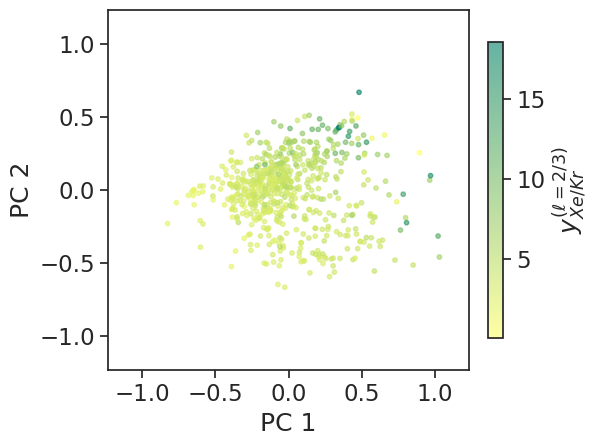

In [21]:
cmap_name = cm.summer_r # sequential colormap (reversed)

###
#  low dimensional (PCA) visualization of the entire dataset
###
fig = plt.figure()
plt.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name, s=10, alpha=0.6)

###
#  axis commands
###
ax_lim = max([np.max(X_2D), abs(np.min(X_2D))]) + 0.2
plt.xlim([-ax_lim, ax_lim])
plt.ylim([-ax_lim, ax_lim])

plt.xticks()
plt.yticks()
plt.xlabel('PC 1')
plt.ylabel('PC 2')
cb = plt.colorbar(fraction=0.03, pad=0.04)
cb.set_label(label="$y^{(\ell=2/3)}_{Xe/Kr}$")

plt.gca().set_aspect('equal', 'box')

plt.tight_layout()
if save_plots:
    plt.savefig("./figs/PCA_feature_space_colored_by_GCMC_Selectivity.pdf", format="pdf")
plt.show()

In [22]:
nb = 6
acq = mfbo_res['acquired_set'][0][:nb]
lf_acq = acq[acq[:, 0] == lf_val, :] # low-fidelity
lf_acq[:nb, 1].astype(int)

array([112, 522,  45])

In [23]:
hf_acq = acq[acq[:, 0] == hf_val, :] # high-fidelity
hf_acq

array([[  0.6666667, 112.       ],
       [  0.6666667, 522.       ],
       [  0.6666667,  45.       ]], dtype=float32)

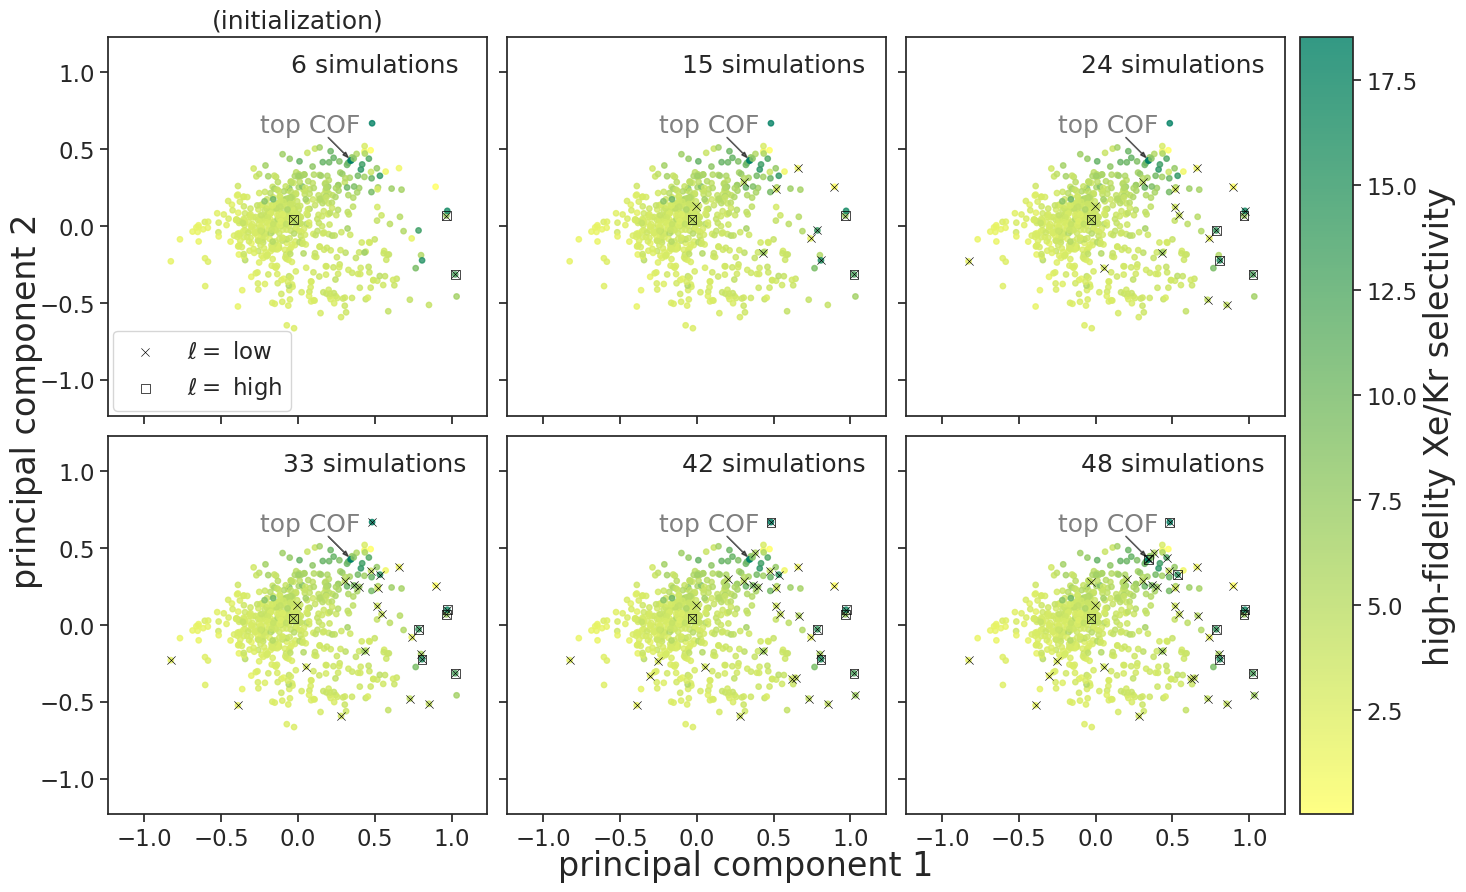

In [24]:
panel_step = np.ceil((mfbo_res['BO_iter_top_cof_acquired'][0] - 2*nb_COFs_initialization) / 5)

nb_acquired = [2*nb_COFs_initialization + i*int(panel_step) for i in range(6)]

nb_acquired[len(nb_acquired) - 1] = mfbo_res['BO_iter_top_cof_acquired'][0] + 1 # have to adjust the indexing

# set up figure and image grid
fig = plt.figure(figsize=[3*6.4 + 0.5, 4.8*2 + 0.5])

grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                 nrows_ncols=(2, 3),
                 axes_pad=0.2,
                 share_all=True,
                 cbar_location="right",
                 cbar_mode="single",
                 cbar_size="7%",
                 cbar_pad=0.15,
                 )

# add data to image grid
for (i, nb), ax in zip(enumerate(nb_acquired), grid):
    acq = mfbo_res['acquired_set'][0][:nb]
    lf_acq = acq[acq[:, 0] == lf_val, :] # low-fidelity
    hf_acq = acq[acq[:, 0] == hf_val, :] # high-fidelity
    assert len(lf_acq) + len(hf_acq) == len(acq)

    ###
    #  plot PCA for all COFs
    ###
    pca_base = ax.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name,
                             facecolor='none', s=15, alpha=0.8) 
    

    ###
    #  indicate top COF
    #  arrow is drawn from (x, y) to (x+dx, y+dy)
    ###
    top_cof_id = np.argmax(y[1])
    eps = 0.15
    ax.arrow(X_2D[top_cof_id, 0]-eps, X_2D[top_cof_id, 1]+eps, eps*0.7, -eps*0.7,
             head_width=0.025, color='k', alpha=0.6)
    ax.text(X_2D[top_cof_id, 0]-3.95*eps, X_2D[top_cof_id, 1]+1.2*eps, 'top COF', color="grey")

    ###
    #  indicate acquired points at the given iteration
    ###
    # low-fidelity
    ax.scatter(X_2D[lf_acq[:nb, 1].astype(int), 0], X_2D[lf_acq[:nb, 1].astype(int), 1], 
                  label="$\ell =$ low",
                  color='k', marker='x', s=35, lw=0.45, zorder=2) 
    # high-fidelity
    ax.scatter(X_2D[hf_acq[:nb, 1].astype(int), 0], X_2D[hf_acq[:nb, 1].astype(int), 1], 
               label="$\ell =$ high",
               fc='none', ec='k', marker='s', s=40, lw=0.5, zorder=10)
    

    
    # subplot titles --- use ax.text 
    if i == 0:
        ax.set_title('(initialization)')
    ax.text(0.5, 1.0, '{} simulations'.format(nb_acquired[i]), ha='center')
        
    ax.tick_params(axis='x')
    ax.set_aspect('equal', 'box')

###
#  colorbar
###
cb = ax.cax.colorbar(pca_base)
cb.set_label(label="high-fidelity Xe/Kr selectivity", fontsize=24)
# cb.set_label(label="$y^{(\ell=2/3)}_{Xe/Kr}$", fontsize=24)

###
#  axis commands
###
grid[0].legend(loc=(0.013, 0.013))
fig.text(0.155, 0.52, 'principal component 2', ha='center', va='center', rotation='vertical', fontsize=24)
fig.text(0.52, 0.05, 'principal component 1', ha='center', fontsize=24)

grid[0].set_xlim([-ax_lim, ax_lim])
grid[0].set_ylim([-ax_lim, ax_lim])


if save_plots:
    plt.savefig("./figs/MFBO_PCA_dynamics.pdf", bbox_inches="tight", format="pdf")
plt.show()

### make PCA figs to compile into a GIF.

In [25]:
make_plots_for_gif = False

In [26]:
iter_stop = mfbo_res['BO_iter_top_cof_acquired'][0] - 2*nb_COFs_initialization

nb_acquired = [2*nb_COFs_initialization + i for i in range(iter_stop)]

nb_acquired[len(nb_acquired) - 1] = mfbo_res['BO_iter_top_cof_acquired'][0] + 1 # have to adjust the indexing

if make_plots_for_gif:
    # add data to image grid
    for (i, nb) in enumerate(nb_acquired):
        acq = mfbo_res['acquired_set'][0][:nb]
        lf_acq = acq[acq[:, 0] == lf_val, :] # low-fidelity
        hf_acq = acq[acq[:, 0] == hf_val, :] # high-fidelity
        assert len(lf_acq) + len(hf_acq) == len(acq)

        ###
        #  figure
        ###
        fig = plt.figure(figsize=(6, 6), dpi=300)
        cmap_name = cm.summer_r # sequential colormap (reversed)
        grid = ImageGrid(fig, 111,          # as in plt.subplot(111)
                    nrows_ncols=(1, 1),
                    axes_pad=0.2,
                    share_all=True,
                    cbar_location="right",
                    cbar_mode="single",
                    cbar_size="7%",
                    cbar_pad=0.15,
                    )

        ax = grid[0]
        ###
        #  plot PCA for all COFs
        ###
        pca_base = ax.scatter(X_2D[:, 0], X_2D[:, 1], c=y[1], cmap=cmap_name,
                                facecolor='none', s=15, alpha=0.8) 
        

        ###
        #  indicate top COF
        #  arrow is drawn from (x, y) to (x+dx, y+dy)
        ###
        top_cof_id = np.argmax(y[1])
        eps = 0.15
        ax.arrow(X_2D[top_cof_id, 0]-eps, X_2D[top_cof_id, 1]+eps, eps*0.7, -eps*0.7,
                head_width=0.025, color='k', alpha=0.6)
        ax.text(X_2D[top_cof_id, 0]-3.95*eps, X_2D[top_cof_id, 1]+1.2*eps, 'top COF', color="grey")

        ###
        #  indicate acquired points at the given iteration
        ###
        # low-fidelity
        ax.scatter(X_2D[lf_acq[:nb, 1].astype(int), 0], X_2D[lf_acq[:nb, 1].astype(int), 1], 
                    label="$\ell=1/3$",
                    color='k', marker='x', s=35, lw=0.45, zorder=2) 
        # high-fidelity
        ax.scatter(X_2D[hf_acq[:nb, 1].astype(int), 0], X_2D[hf_acq[:nb, 1].astype(int), 1], 
                label="$\ell=2/3$",
                fc='none', ec='k', marker='s', s=40, lw=0.5, zorder=10)

        # subplot titles --- use ax.text 
        if i == 0:
            ax.text(0.1, 1.0, '(initialization) {} experiments'.format(nb_acquired[i]), ha='center')
            # ax.text('(initialization)')
        else:
            ax.text(0.5, 1.0, '{} experiments'.format(nb_acquired[i]), ha='center')
            
        ax.tick_params(axis='x')
        ax.set_aspect('equal', 'box')

        ###
        #  colorbar
        ###
        cb = ax.cax.colorbar(pca_base)
        cb.set_label(label="$y^{(\ell=2/3)}_{Xe/Kr}$", fontsize=24)

        ###
        #  axis commands
        ###
        grid[0].legend(loc=(0.013, 0.013))
        # fig.text(0.155, 0.52, 'principal component 2', ha='center', va='center', rotation='vertical', fontsize=24)
        fig.text(-0.025, 0.52, 'principal component 2', ha='center', va='center', rotation='vertical', fontsize=24)
        fig.text(0.52, 0.05, 'principal component 1', ha='center', fontsize=24)
        grid[0].set_xlim([-ax_lim, ax_lim])
        grid[0].set_ylim([-ax_lim, ax_lim])

        if save_plots:
            plt.savefig("./figs/pca_dynamics/MFBO_PCA_dynamics_{}.png".format(i), bbox_inches="tight", format="png")
        plt.show()


# Radar Plot of Feature Vector

custom scale on each axis adapted from code [here](https://datascience.stackexchange.com/questions/6084/how-do-i-create-a-complex-radar-chart)

In [27]:
###
#  load data
###
cof_file = h5py.File("top_COF_feature_vector.jld2", "r")
values = np.array(cof_file['features']).tolist() # has 14 entries
print("Top COF ID = ", top_cof_id)
print("Top COF feature vector:\n", values)

# descriptors
property_type = ['geometric', 'chemical']
descriptors = []

for prop in property_type:
    filename = "descriptors/{}_properties.csv".format(prop)
    df = pd.read_csv(filename)
    for descriptor in df.columns:
        if descriptor != "crystal_name": 
            descriptors.append(descriptor)
            
###
#  fix labels for plotting
###
pretty_des_names = dict({'pore_diameter_Å': 'pore\ndiameter [Å]', 
                         'void_fraction': 'void fraction',
                         'surface_area_m²g⁻¹': 'surface area [m² g⁻¹]',
                         'crystal_density': 'crystal density [kg m⁻³]'
                        })

for n, des in enumerate(descriptors):
    if des in pretty_des_names.keys():
        descriptors[n] = pretty_des_names[des] + ''
    else:
        descriptors[n] = descriptors[n] + ""
        
print("feature labels: \n", descriptors)

Top COF ID =  375
Top COF feature vector:
 [5.74091, 0.33218, 4502.94, 1071.1983709342826, 0.0, 0.0, 0.5369127516778524, 0.348993288590604, 0.0, 0.10738255033557047, 0.0, 0.0, 0.0, 0.006711409395973154]
feature labels: 
 ['pore\ndiameter [Å]', 'void fraction', 'surface area [m² g⁻¹]', 'crystal density [kg m⁻³]', 'B', 'O', 'C', 'H', 'Si', 'N', 'S', 'P', 'halogens', 'metals']


In [28]:
def _scale_data(data, ranges):
    """scales data[1:] to ranges[0]"""
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        assert (y1 <= d <= y2) or (y2 <= d <= y1)
    x1, x2 = ranges[0]
    sdata = [data[0]] 
    for d, (y1, y2) in zip(data[1:], ranges[1:]):
        sdata.append((d - y1) / (y2 - y1) * (x2 - x1) + x1)
    return sdata

class ComplexRadar():
    def __init__(self, fig, variables, ranges, n_ordinate_levels=6):
        # divide circle into equal parts
        angles = np.arange(0, 360, 360./len(variables))
        
        # make a list of the axes (one per dscriptor variable)
        # [0.1, 0.1, 0.9, 0.9]
        axes = [fig.add_axes([0.0, 0.0, 1.0, 1.0], polar=True, label="axes{}".format(i)) 
                for i in range(len(variables))]
        
        # put variable name at the correct angle
        # adjust rotation of text for readability
        l, text = axes[0].set_thetagrids(angles, labels=variables, fontsize=26)
        [txt.set_rotation(angle-90) for txt, angle in zip(text, angles)] 
        
        # overlay each axis
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.grid("off", lw=1)
            ax.xaxis.set_visible(False)
            
        # specify grid labels
        for i, ax in enumerate(axes): 
            # ax.set_axisbelow(False)
            ax.yaxis.set_zorder(0)

            grid = np.linspace(*ranges[i], num=n_ordinate_levels)
            gridlabel = [] #["{0:.2f}".format(round(x, 2)) for x in grid]
            for j, x in enumerate(grid):
                if j == 0 or j == len(grid)-1:
                    gridlabel.append("{0:.1f}".format(round(x, 2)))
                else:
                    gridlabel.append('')
            
            gridlabel[0] = "" # clean up origin

            lines, labels = ax.set_rgrids(grid, labels=gridlabel, angle=angles[i], fontsize=20, color='grey') 
            
            ###
            #  Go through labels and adjust alignment based on where
            #  it is in the circle.
            ###
            for label in labels:
                if angles[i] == 0:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('bottom')
                elif 0 < angles[i] < 55:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('top')
                elif 55 <= angles[i] < 90:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('top')
                elif 90 <= angles[i] < 180:
                    label.set_horizontalalignment('left')
                    label.set_verticalalignment('top')
                elif angles[i] == 180.0:
                    label.set_horizontalalignment('left')
                    label.set_verticalalignment('bottom')
                elif 180 < angles[i] < 225:
                    label.set_horizontalalignment('left')
                    label.set_verticalalignment('bottom')
                elif 225 <=  angles[i] < 270:
                    label.set_horizontalalignment('left')
                    label.set_verticalalignment('bottom')
                elif 270 <=  angles[i] < 300:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('bottom')
                elif 300 <= angles[i]:
                    label.set_horizontalalignment('right')
                    label.set_verticalalignment('baseline')
            
            # if i == 0:
            #     ax.set_zorder(10)
            # else:
            #     ax.set_zorder(10)
            ax.spines["polar"].set_visible(False)
            ax.set_ylim(*ranges[i])
        
        ###    
        #  variables for plotting
        ###
        self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

        
    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)
        # put this one on top so gridlines don't overlap data
        self.ax.set_zorder(100)
        
        self.ax.spines["polar"].set_visible(True)

        ###
        #  Go through labels and adjust alignment based on where
        #  it is in the circle.
        ###
        for label, angle in zip(self.ax.get_xticklabels(), self.angle):
            ang = np.rad2deg(angle)
            if ang == 0:
                label.set_horizontalalignment('left')
                label.set_verticalalignment('center_baseline')
            elif 0 < ang < 90:
                label.set_horizontalalignment('left')
                label.set_verticalalignment('center_baseline')
            elif 55 <= ang < 90:
                label.set_horizontalalignment('right')
                label.set_verticalalignment('bottom')
            elif 90 <= ang < 180:
                label.set_horizontalalignment('center')
                label.set_verticalalignment('center_baseline')
            elif ang == 180.0:
                label.set_horizontalalignment('center')
                label.set_verticalalignment('center')
            elif 180 < ang < 225:
                label.set_horizontalalignment('center')
                label.set_verticalalignment('center_baseline')
            elif 225 <=  ang < 270:
                label.set_horizontalalignment('center')
                label.set_verticalalignment('center_baseline')
            elif 270 <=  ang:
                label.set_horizontalalignment('left')
                label.set_verticalalignment('center')
        ###        
        #  make the pannel transparent so you can see the 
        #  plot labels below it
        ###
        self.ax.patch.set_alpha(0.0)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)


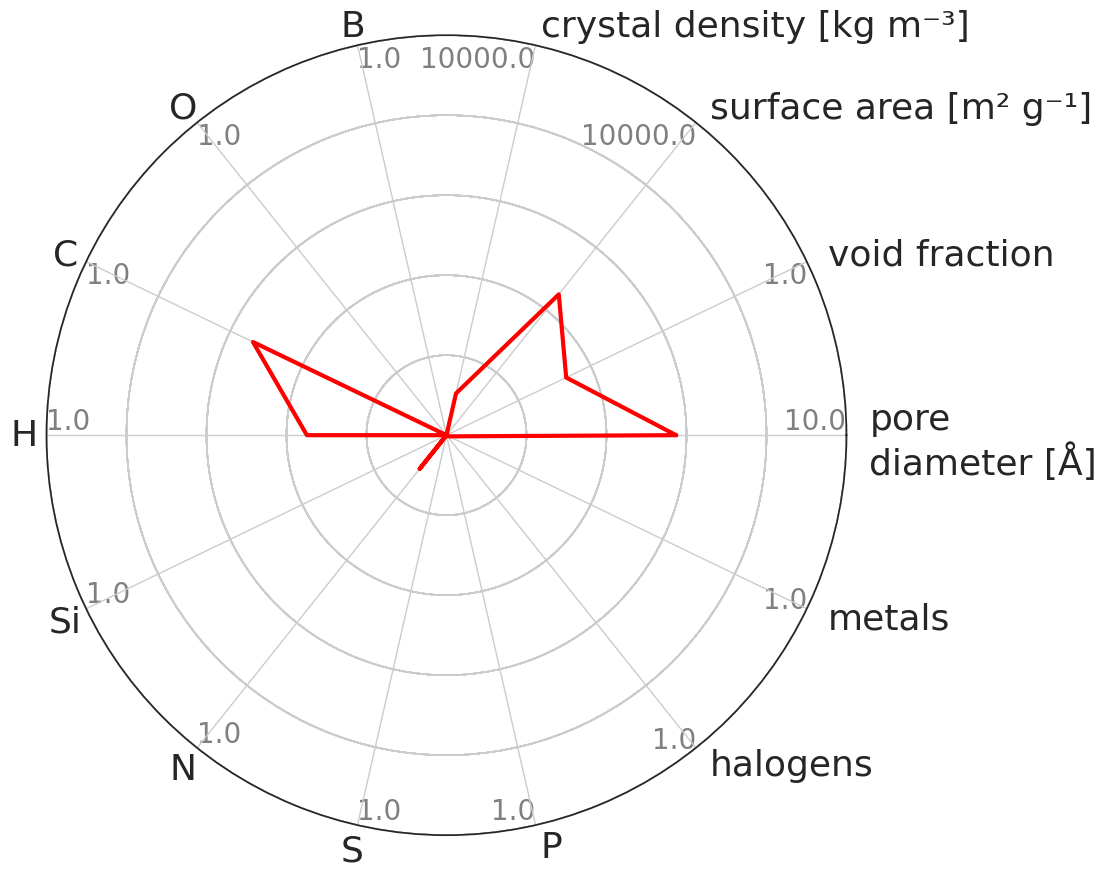

In [29]:
###
#  data
###
variables = tuple(descriptors)
data = tuple(values)
# ymax will be 10**(base) 
ranges = []
for val in values:
    if 0 <= val <= 1:
        base = 0
    else:
        base = int(np.ceil(np.log10(val)))
    ranges.append((0, 10**base))
    
###
#  plotting
###
fig1 = plt.figure(figsize=(8, 8)) 
radar = ComplexRadar(fig1, variables, ranges)
radar.plot(data, color='red', alpha=1.0, lw=3) 
# radar.fill(data, color='red', alpha=0.25)

if save_plots:
    plt.savefig("./figs/top_COF_raw_feature_vector_radar.pdf", bbox_inches="tight", format='pdf')
plt.show()

### radar plot multiple cofs

In [30]:
###
#  get COF ids 
###
num_at_performance = 15 # how many ids to get

# np.argsort() is in ascending order, so top COFs at the end of list
poor_performning_cofs = np.argsort(y[1])[:num_at_performance]
print("IDs of top performing COFs: ", poor_performning_cofs)

high_performing_cofs = np.argsort(y[1])[-num_at_performance:]
print("IDs of top performing COFs: ", high_performing_cofs)

# compile into a single list
cof_ids_to_include = [poor_performning_cofs, high_performing_cofs]
performing_cofs = np.array([item for sublist in cof_ids_to_include for item in sublist])


###
#  load in data
###
targets_and_features = h5py.File("targets_and_raw_features.jld2", "r")
# keys: ['X', 'gcmc_elapsed_time', 'gcmc_y', 'henry_total_elapsed_time', 'henry_y'
# targets_and_features.keys()
cof_feature_values = np.array(targets_and_features['X'])
print('shape of feature matrix: {}'.format(cof_feature_values.shape)) # (14, 608) => each featue is a 
# len(cof_feature_values[:, 0]) # 14, features for a given COF
# len(cof_feature_values[1])    # 608, given feature for all COFs


###
#  get feature vector for desired COFs
###
performing_cof_features = cof_feature_values[:, performing_cofs]


###
#  construct data for radar plot
###
variables = tuple(descriptors) # descriptors defined above
values = performing_cof_features
data = [tuple(v) for v in values.transpose()]
# len(data[0])

IDs of top performing COFs:  [526  98 262 336 338 167 425 292 426 291 176   0 427   7 194]
IDs of top performing COFs:  [332 527 364  50 522 234 523 574 212 200 521 319 237 376 375]
shape of feature matrix: (14, 608)


In [31]:
###
#  get data ranges for grid
###
ranges = [(0, 0) for i in range(len(values))] 
for k, feature in enumerate(values):
    for val in feature:
        if 0 <= val <= 1:
            base = 0
        else: 
            base = int(np.ceil(np.log10(val)))

        if int(ranges[k][1]) <= 10**base:
            ranges[k] = tuple([0, 10**base])

print(ranges)

[(0, 100), (0, 1), (0, 10000), (0, 10000), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1), (0, 1)]


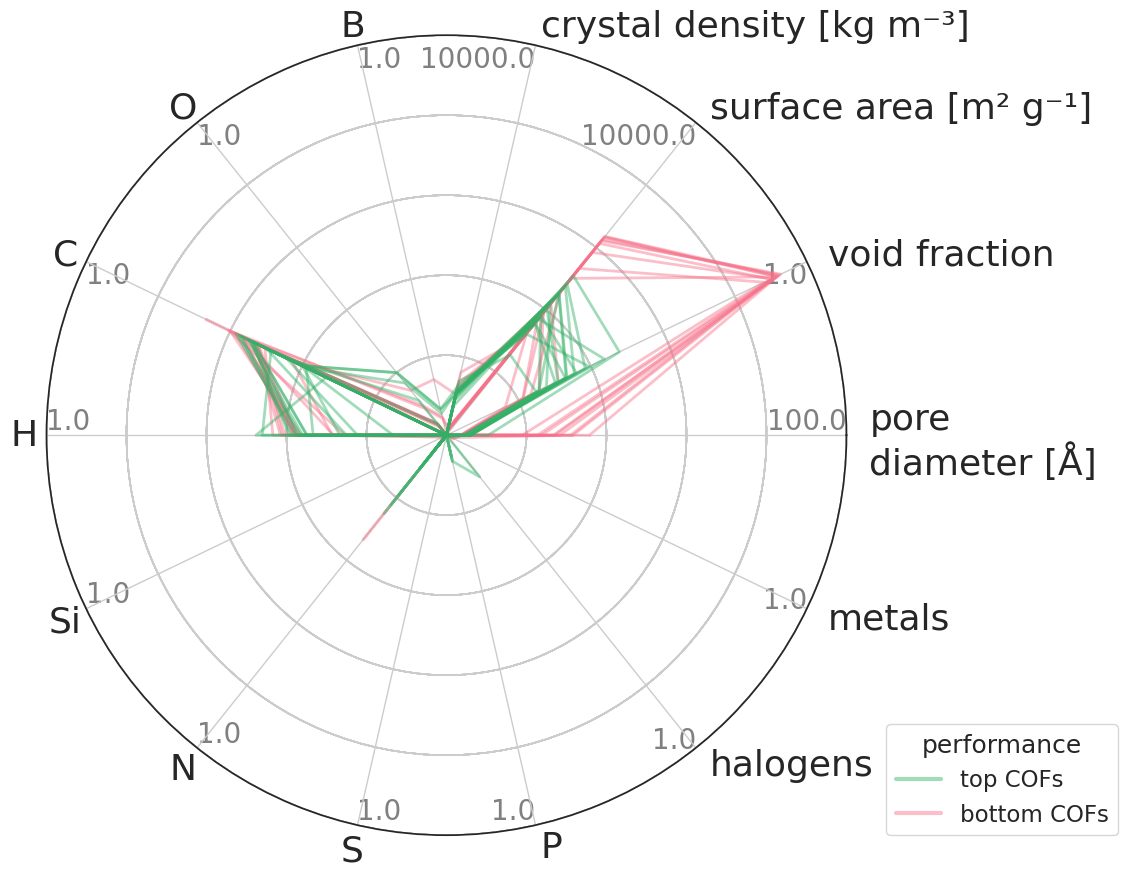

In [32]:
##
#  plotting
###
cpl = sns.color_palette("hls", 8)
fig1 = plt.figure(figsize=(8, 8)) 
radar = ComplexRadar(fig1, variables, ranges)

# define a color set
bottom_c = sns.color_palette("husl", 8)[0]
top_c = sns.color_palette("husl", 8)[3]

for j, d in enumerate(data):
    if j < num_at_performance:
        color = bottom_c
    else:
        color = top_c
    radar.plot(d, color=color, alpha=0.45, lw=2) 
    # radar.fill(d, color=color, alpha=0.15)

###
#  dummy plots for legend labels
###
p_empty_sqr = plt.plot([], linestyle='-', label='top COFs', color=top_c, alpha=0.45)

p_empty_cir = plt.plot([], linestyle='-', label='bottom COFs', color=bottom_c, alpha=0.45)

plt.legend(loc=[1.05, 0.00], ncol=1, title='performance')

if save_plots:
    plt.savefig("./figs/compare_COFs_raw_feature_vectors_radar.pdf", bbox_inches="tight", format='pdf')
plt.show()

# Plot Correlation of Features to Selectivity

1. Make a histogram for the raw features so we can get an idea for the distribution in the data set
2. make a grid (only need lower diag.) of the features and use a colorbar for the selectivity
    - print the correlation foefficient? 
    - I would expect no corelation between, say, carbon content and Boron content...  
    - maybe could do this as a heatmap, but then loose the information about the selectivity
3. could just generate scatter plots where the vertical axis 
    - x-axis: feature
    - y-axis: GCMC selectivity
    - could put subplots on a grid to save space

4. could also many do a histogam which shares an x-axis with the scatter plot (feature axis)

note - we want the raw features

In [33]:
###
#  features and molecular simulation data
###
normalization = "normalized" 
raw_feature_file = h5py.File("targets_and_raw_features.jld2".format(normalization), "r")

# feature matrix
X_raw = torch.from_numpy(np.transpose(raw_feature_file["X"][:])) 

# simulation data
y_raw = [np.transpose(raw_feature_file["henry_y"][:]), 
     np.transpose(raw_feature_file["gcmc_y"][:])]  

# associated simulation costs
raw_cost = [np.transpose(raw_feature_file["henry_total_elapsed_time"][:]), # [min]
        np.transpose(raw_feature_file["gcmc_elapsed_time"][:])]        # [min]

X_raw.shape
print("X_raw[i, :] - each row (i) is a COF")
print("X_raw[:, j] - each column (j) is a feature")
print("list of features:")
print(descriptors)

X_raw[i, :] - each row (i) is a COF
X_raw[:, j] - each column (j) is a feature
list of features:
['pore\ndiameter [Å]', 'void fraction', 'surface area [m² g⁻¹]', 'crystal density [kg m⁻³]', 'B', 'O', 'C', 'H', 'Si', 'N', 'S', 'P', 'halogens', 'metals']


In [34]:
descriptors[0] = 'pore diameter [Å]' # need to clean up name

FileNotFoundError: [Errno 2] No such file or directory: './figs/feature_correlations/selectivity_vs_pore_diameter.pdf'

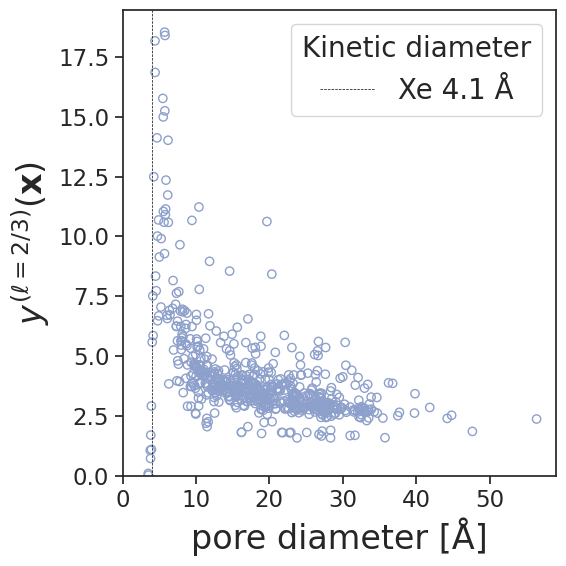

In [35]:
# loop over the features and plot the correlatins
for i, des in enumerate(descriptors):
    lbl_fs = 24 # label fontsize
    if i > 3:
        lbl_fs = 36

    fig = plt.figure(figsize=(6,6))
    plt.scatter(X_raw[:, i], y_raw[1], fc="none", ec="C2")
    #  kinetic diameter of Kr (~3.60 Å) and Xe (~4.1 Å)
    if 'diameter' in des:
        # plt.axvline(x=3.60, label="Kr", color='k', lw=0.5, linestyle=":")
        plt.axvline(x=3.96, label="Xe 4.1 Å", color='k', lw=0.5, linestyle="--")
        plt.legend(title=r"Kinetic diameter", fontsize=20, title_fontsize=20)

    if des in ['B', 'O', 'C', 'H', 'Si', 'N', 'S', 'P', 'halogens', 'metals']:
        plt.xlabel("fraction " + des, fontsize=lbl_fs)
    else:
        plt.xlabel(des, fontsize=lbl_fs)

    plt.ylabel(r"$y^{(\ell=2/3)}(\mathbf{x})$", fontsize=lbl_fs)
    
    plt.xlim(xmin=0)
    if X_raw[:, i].max().item() < 1.1:
        plt.xlim(xmax=1.0)

    plt.ylim(ymin=0)

    plt.tight_layout()
    if save_plots:
        if ('[' in des):
            # remove units from filename
            nn = np.where(['[' in s for s in des.split()])[0].item()
            fig_name = des.split()[:nn]
        else:
            fig_name = des.split()
        
        plt.savefig("./figs/feature_correlations/selectivity_vs_{}.pdf".format("_".join(fig_name)), format='pdf')
    plt.show()